In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb

from cinnamon.drift import ModelDriftExplainer

# Breast Cancer Data

In [2]:
dataset = datasets.load_breast_cancer()

In [3]:
X = pd.DataFrame(dataset.data, columns = dataset.feature_names)
y = dataset.target

In [4]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Build XGBoost model

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

In [6]:
clf = XGBClassifier(n_estimators=1000,
                    booster="gbtree",
                    objective="binary:logistic",
                    learning_rate=0.05,
                    max_depth=6,
                    use_label_encoder=False,
                    seed=2021)

In [7]:
clf.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20, verbose=10)

[21:25:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.65349
[10]	validation_0-logloss:0.39963
[20]	validation_0-logloss:0.28059
[30]	validation_0-logloss:0.21149
[40]	validation_0-logloss:0.16765
[50]	validation_0-logloss:0.14519
[60]	validation_0-logloss:0.13101
[70]	validation_0-logloss:0.12157
[80]	validation_0-logloss:0.11758
[90]	validation_0-logloss:0.11513
[100]	validation_0-logloss:0.11288
[110]	validation_0-logloss:0.11233
[120]	validation_0-logloss:0.11187
[130]	validation_0-logloss:0.11200
[140]	validation_0-logloss:0.11186
[144]	validation_0-logloss:0.11212


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=2021, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

# Analyze data drift with ModelDriftExplainer

The experiment is done with a random split so we should not detect a data drift

In [8]:
drift_explainer = ModelDriftExplainer(clf)

In [9]:
drift_explainer.fit(X1=X_train, X2=X_test, y1=y_train, y2=y_test)

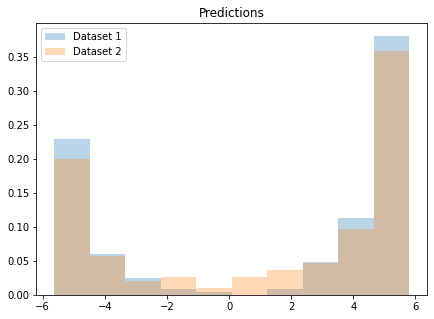

[DriftMetricsNum(mean_difference=0.005498574879272855, wasserstein=0.3764544601013494, ks_test=BaseStatisticalTestResult(statistic=0.08323782655969908, pvalue=0.35428891768775117))]

In [10]:
# no apparent drift in distributions of logit predictions
drift_explainer.plot_prediction_drift()
drift_explainer.get_prediction_drift()

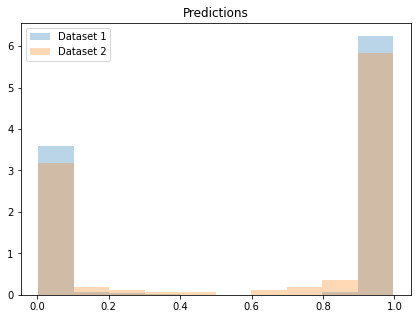

[DriftMetricsNum(mean_difference=0.00798452225707491, wasserstein=0.024082025832758043, ks_test=BaseStatisticalTestResult(statistic=0.08323782655969908, pvalue=0.35428891768775117))]

In [11]:
# same thing for distributions of predicted probabilities
drift_explainer.plot_prediction_drift(prediction_type='proba')
drift_explainer.get_prediction_drift(prediction_type='proba')

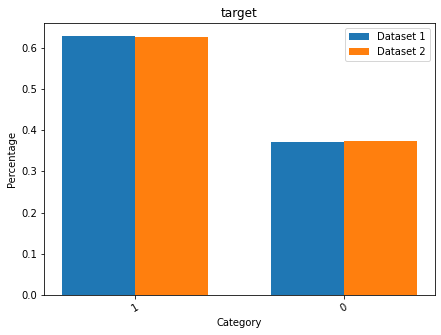

DriftMetricsCat(wasserstein=0.0024097093655411628, jensen_shannon=0.0017616379091961293, chi2_test=Chi2TestResult(statistic=0.0, pvalue=1.0, dof=1, contingency_table=        0      1
X1  148.0  250.0
X2   64.0  107.0))

In [12]:
# no apparent drift in distributions of target labels
drift_explainer.plot_target_drift()
drift_explainer.get_target_drift()

In [13]:
drift_explainer.get_performance_metrics_drift()

PerformanceMetricsDrift(dataset1=ClassificationMetrics(accuracy=1.0, log_loss=0.016039305599991362), dataset2=ClassificationMetrics(accuracy=0.9473684210526315, log_loss=0.11116574995208815))

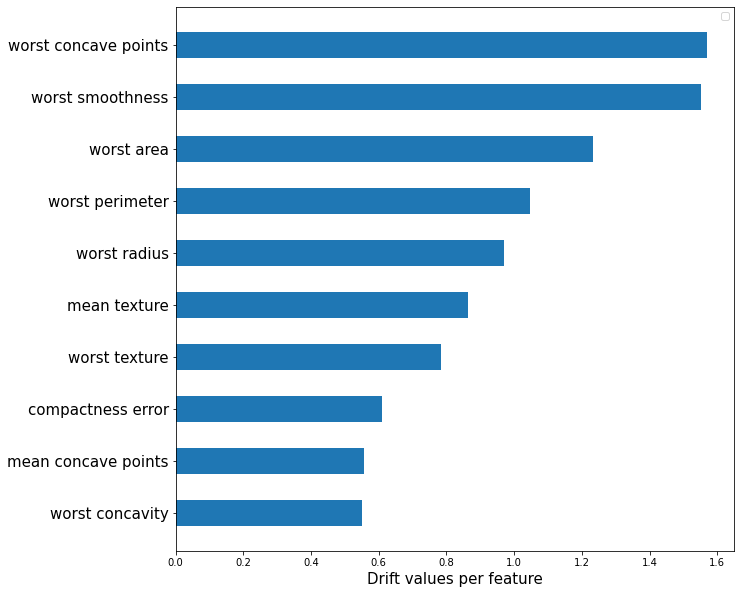

In [14]:
# plot drift values computed with the tree based approach (only for demonstration
# purpose since there is no data drift)
drift_explainer.plot_tree_based_drift_values(type='node_size')

In [15]:
# drift values with the tree based approach
drift_explainer.get_tree_based_drift_values(type='node_size')

array([[0.1263785 ],
       [0.86245768],
       [0.03015075],
       [0.5015792 ],
       [0.345185  ],
       [0.01076813],
       [0.48651996],
       [0.5553289 ],
       [0.00502513],
       [0.02160804],
       [0.05284761],
       [0.16747726],
       [0.01615219],
       [0.21016901],
       [0.06186914],
       [0.61067109],
       [0.13051384],
       [0.00904523],
       [0.1728764 ],
       [0.0583929 ],
       [0.970708  ],
       [0.78384477],
       [1.04602337],
       [1.23239211],
       [1.55243827],
       [0.09348557],
       [0.55188395],
       [1.57008003],
       [0.27572543],
       [0.05313921]])

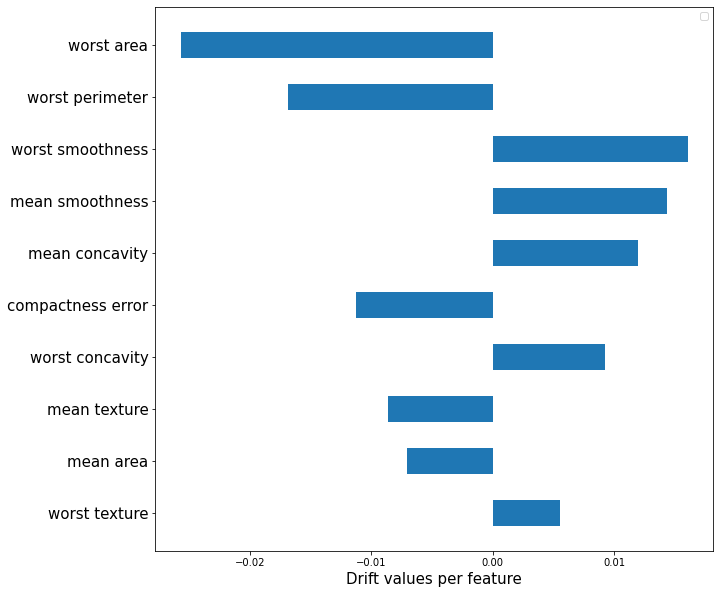

In [16]:
# plot drift values for type='mean_norm'
drift_explainer.plot_tree_based_drift_values(type='mean_norm')

In [17]:
drift_explainer.get_tree_based_drift_values(type='mean_norm')

array([[ 0.00128017],
       [-0.00862285],
       [ 0.00227804],
       [-0.00702226],
       [ 0.01434936],
       [ 0.00044783],
       [ 0.01191792],
       [ 0.00368157],
       [-0.0001583 ],
       [-0.00016892],
       [ 0.00055728],
       [ 0.00208376],
       [-0.00037917],
       [-0.00193379],
       [-0.00055455],
       [-0.0112573 ],
       [ 0.00458787],
       [-0.00033537],
       [ 0.00311544],
       [-0.00054474],
       [-0.00204518],
       [ 0.00557142],
       [-0.01681621],
       [-0.02567387],
       [ 0.01606102],
       [-0.00331497],
       [ 0.00925461],
       [-0.00053606],
       [ 0.00542589],
       [-0.00056559]])

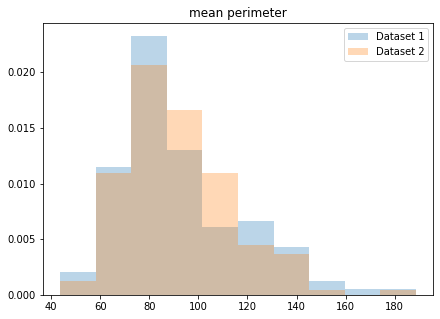

DriftMetricsNum(mean_difference=-0.5394598724617197, wasserstein=3.3009656469481903, ks_test=BaseStatisticalTestResult(statistic=0.07401040289165124, pvalue=0.4998149146505402))

In [18]:
drift_explainer.plot_feature_drift('mean perimeter')
drift_explainer.get_feature_drift('mean perimeter')

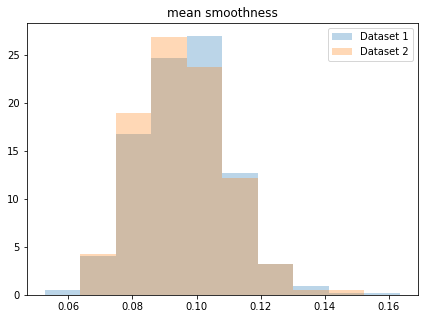

DriftMetricsNum(mean_difference=-0.0011612596608774894, wasserstein=0.0016581176349584157, ks_test=BaseStatisticalTestResult(statistic=0.10195715419201269, pvalue=0.15288885704183494))

In [19]:
drift_explainer.plot_feature_drift(4)
drift_explainer.get_feature_drift(4)

In [20]:
drift_explainer.get_feature_drifts()

[DriftMetricsNum(mean_difference=-0.06832955714243738, wasserstein=0.5165887184460309, ks_test=BaseStatisticalTestResult(statistic=0.07067501248934732, pvalue=0.558530379618637)),
 DriftMetricsNum(mean_difference=0.014966205295483093, wasserstein=0.48581195450938897, ks_test=BaseStatisticalTestResult(statistic=0.07262922801140204, pvalue=0.5235102002710169)),
 DriftMetricsNum(mean_difference=-0.5394598724617197, wasserstein=3.3009656469481903, ks_test=BaseStatisticalTestResult(statistic=0.07401040289165124, pvalue=0.4998149146505402)),
 DriftMetricsNum(mean_difference=-17.377639660289788, wasserstein=51.29123100884536, ks_test=BaseStatisticalTestResult(statistic=0.06404831173410915, pvalue=0.6798041178199971)),
 DriftMetricsNum(mean_difference=-0.0011612596608774894, wasserstein=0.0016581176349584157, ks_test=BaseStatisticalTestResult(statistic=0.10195715419201269, pvalue=0.15288885704183494)),
 DriftMetricsNum(mean_difference=-0.003067542684181135, wasserstein=0.006741856651679452, ks